In [1]:
import gym
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.ppo.policies import CnnPolicy
from stable_baselines3.ppo.policies import MlpPolicy
from utils.adversary_env import AdversaryEnv
from utils.cartpole_wrapper import CartPoleWrapper
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

# CONST
N_EPISODES = 25

# Load target model
target_model = A2C.load("../a2c/model/lunarlander_v2_a2c_3M_to_11M")

In [2]:
# Test target model - for info on why the env is wrapped with Monitor check the evaluate_policy function
mean_reward, std_reward = evaluate_policy(target_model, Monitor(gym.make('LunarLander-v2')), n_eval_episodes=N_EPISODES)
print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward: 229.93 +/- 84.24


In [3]:
# Create adversary with adversary env
# adversary_env = AdversaryEnv(gym.make('LunarLander-v2'), target_model)
# adversary = PPO(MlpPolicy, adversary_env, verbose=1)

In [4]:
# Train adversary
# log_dir = "./out/training-log/"
# log_path = log_dir + f"adversary-adversary-lunarlander-v2/"
# save_dir = "./models/adversary-lunarlander-v2/"

# timesteps = 50000

# adversary.learn(
#         total_timesteps=timesteps,
#         callback=None,
#         log_interval=-1,
#         eval_env=adversary_env, 
#         eval_freq=5000, 
#         n_eval_episodes=100,
#         tb_log_name='PPO',
#         eval_log_path=log_path, 
#         reset_num_timesteps=False
#         )

# # Save adversary
# adversary.save(save_dir + f"adversary_lunarlander_v2_{timesteps}")

In [5]:
# Load adversary
save_dir = "./models/adversary-lunarlander-v2/"

adversary = PPO.load(save_dir + f"adversary_lunarlander_v2_50000")
adversary_env = AdversaryEnv(gym.make('LunarLander-v2'), target_model)

In [ ]:
import numpy as np
import pandas as pd
from strategically_timed_attack import StrategicallyTimedAttack

# Evaluate strategically timed adversarial attack over different beta
data_dict = {
    'beta': [],
    'mean_rew': [],
    'mean_perturbation': [],
    'mean_n_timesteps': [],
    'mean_n_attacks': []
}

for j in range(1, 100):
    beta = j/100

    all_episodes_rewards = []
    all_episodes_perturbation = []
    all_episodes_n_timesteps = []
    all_episodes_n_attacks = []

    for i in range(0, N_EPISODES):
        # Run attack on a2c model
        env = gym.make('LunarLander-v2')
        ua = StrategicallyTimedAttack(env=env, model=target_model, attack=adversary, epsilon=0.25, beta=beta)
        ua.perform_attack()

        all_episodes_rewards.append(ua.reward_total)
        all_episodes_perturbation.append(ua.perturbation_total)
        all_episodes_n_timesteps.append(ua.frames_count)
        all_episodes_n_attacks.append(ua.n_attacks)

        ua.reset_attack()

    data_dict['beta'].append(beta)
    data_dict['mean_rew'].append(np.round(np.mean(all_episodes_rewards), 2))
    data_dict['mean_perturbation'].append(np.round(np.mean(all_episodes_perturbation), 2))
    data_dict['mean_n_timesteps'].append(np.round(np.mean(all_episodes_n_timesteps), 2))
    data_dict['mean_n_attacks'].append(np.round(np.mean(all_episodes_n_attacks), 2))

    print("------------------------------------------")
    print(
        f"{data_dict['beta'][-1] = }: \n" +
        f"{data_dict['mean_rew'][-1] = } \n" +
        f"{data_dict['mean_perturbation'][-1] = } \n" +
        f"{data_dict['mean_n_timesteps'][-1] = } \n" +
        f"{data_dict['mean_n_attacks'][-1] = }"
        )
    print("------------------------------------------")

In [ ]:
print(data_dict)

In [ ]:
# Create DataFrame
data_df = pd.DataFrame(
        data_dict, 
        columns=data_dict.keys(),
        )
data_df.set_index('beta', inplace=True)

# Save data as .csv file
with open("./out/data/" + "strategically_timed_attack_beta", 'w') as f:
    data_df.to_csv(f)

data_df

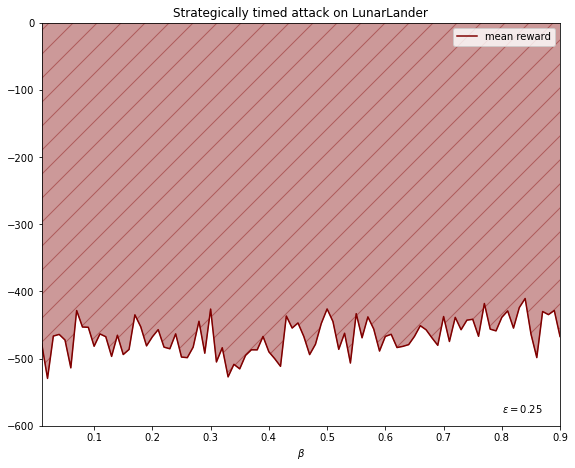

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Load data
with open("./out/data/" + "strategically_timed_attack_beta", 'r') as f:
    data_df = pd.read_csv(f, index_col=0)

# Plot data_df
fig = plt.figure(figsize=(9,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.plot(data_df.index, data_df['mean_rew'], color='maroon', label='mean reward', alpha=1, zorder=0)
plt.fill_between(data_df.index, data_df['mean_rew'], color='maroon', hatch='/', step=None, alpha=0.4)
# plt.vlines(data_df.index, ymin=0, ymax=data_df['mean_rew'], color=np.where(data_df['mean_rew'] < 0, 'maroon', 'darkgreen'), alpha=1, zorder=1)
# plt.scatter(data_df.index, data_df['mean_rew'], color=np.where(data_df['mean_rew'] < 0, 'maroon', 'darkgreen'), label='mean reward', marker='D', alpha=1, zorder=2)

# plt.plot(data_df.index, data_df['mean_perturbation'], label='mean perturbation', color='crimson', linestyle='dotted', alpha=1, zorder=0)

# plt.plot(data_df.index, data_df['mean_n_timesteps'], label='mean n timesteps', color='purple', linestyle='dotted', alpha=1, zorder=0)

# plt.plot(data_df.index, data_df['mean_n_attacks'], label='mean n attacks', color='black', linestyle='dashed', alpha=1, zorder=0)

plt.title("Strategically timed attack on LunarLander")
plt.legend()
plt.xlabel('$\\beta$')
# plt.ylabel()
# plt.yscale('symlog')
# plt.axis([0.01, 0.9, -500, 500]) # plt.axis([xmin, xmax, ymin, ymax])
plt.axis([0.01, 0.9, -600, 0.0001])
plt.text(0.8, -580, "$\epsilon = 0.25$")
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.show()

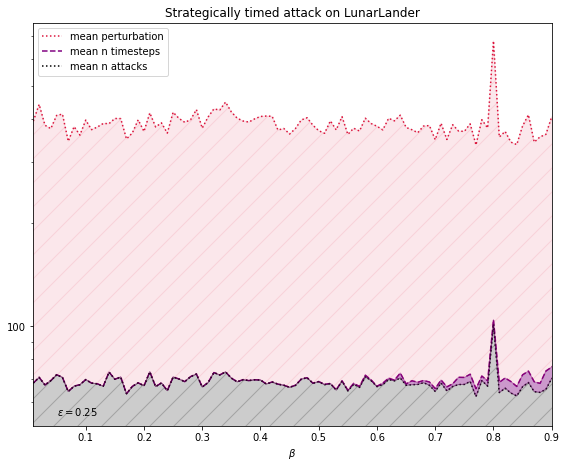

In [14]:
# Plot data_df
fig2 = plt.figure(figsize=(9,7))
ax2 = fig2.add_axes([0.1, 0.1, 0.8, 0.8])
# plt.plot(data_df.index, data_df['mean_rew'], color='darkslategray', alpha=1, zorder=0)
# plt.vlines(data_df.index, ymin=0, ymax=data_df['mean_rew'], color=np.where(data_df['mean_rew'] < 0, 'maroon', 'darkgreen'), alpha=1, zorder=1)
# plt.scatter(data_df.index, data_df['mean_rew'], color=np.where(data_df['mean_rew'] < 0, 'maroon', 'darkgreen'), label='mean reward', marker='D', alpha=1, zorder=2)

plt.plot(data_df.index, data_df['mean_perturbation'], label='mean perturbation', color='crimson', linestyle='dotted', alpha=1, zorder=0)
plt.fill_between(data_df.index, data_df['mean_perturbation'], data_df['mean_n_timesteps'], color='crimson', hatch='/', step=None, alpha=0.1)

plt.plot(data_df.index, data_df['mean_n_timesteps'], label='mean n timesteps', color='purple', linestyle='dashed', alpha=1, zorder=0)
plt.fill_between(data_df.index, data_df['mean_n_timesteps'], data_df['mean_n_attacks'], color='purple', step=None, alpha=0.4)

plt.plot(data_df.index, data_df['mean_n_attacks'], label='mean n attacks', color='black', linestyle='dotted', alpha=1, zorder=0)
plt.fill_between(data_df.index, data_df['mean_n_attacks'], color='black', hatch='/', step=None, alpha=0.2)

plt.title("Strategically timed attack on LunarLander")
plt.legend()
plt.xlabel('$\\beta$')
# plt.ylabel()
plt.yscale('log')
# plt.axis([0.01, 0.9, 0, 250]) # plt.axis([xmin, xmax, ymin, ymax])
plt.xlim([0.01, 0.9])
for axis in [ax2.xaxis, ax2.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.text(0.05, 55, "$\epsilon = 0.25$")
plt.show()